# Elastic and piezoelectric properties with Abinit and AbiPy

This tutorial shows how to calculate the following physical properties related to strain:

  * the *clamped-ion* elastic tensor
  * the *clamped-ion* piezoelectric tensor (insulators only)
  * the *internal* strain tensor
  * the atomic relaxation corrections to the elastic and piezoelectric tensor (*relaxed-ion tensors*)

The discussion is based on the [tutorial on elastic properties](https://docs.abinit.org/tutorial/elastic/)
available on the Abinit web site.
More specifically, we will discuss how to

   * build a flow to compute all the ingredients needed for elastic and piezoelectric tensors
   * use anaddb and AbiPy to obtain the tensors and compute several important physical properties
     starting from the final DDB file produced by the flow
   * perform a convergence study with respect to the k-mesh and use the `DdbRobot` to analyze the convergence.

You might find additional material related to the present section
in the following references (already mentioned in the official tutorial):

* [Systematic treatment of displacements, strains, and electric fields in density-functional perturbation theory](https://dx.doi.org/10.1103/physrevb.72.035105)
* [Metric tensor formulation of strain in density-functional perturbation theory](https://doi.org/10.1103/physrevb.71.035117)

The first paper provides a detailed discussion of the theory underlying the incorporation
of atom-relaxation corrections.
We strongly recommend to read this article as this notebook will mainly focus on the usage
of the python API assuming you are already familiar with the theoretical aspects.
The second paper discusses in more details the DFPT treatment of strain perturbations in Abinit.

If you are already familiar with python and AbiPy-Abinit are already installed and configured,
you may want to use directly the command line interface.
There is a README.md file in the directory of this lesson explaining how to analyze the data from the shell
using ipython and matplotlib.

```{note}
The code in this notebook requires abinit >= 8.9 and abipy >= 0.6
```

## DFPT calculation of elastic and piezolectric tensors

Before starting, we need to import the python modules and the functions needed in the notebook:

In [1]:
import numpy as np
import warnings
warnings.filterwarnings("ignore") # to get rid of deprecation warnings

from abipy import abilab
abilab.enable_notebook() # This line tells AbiPy we are running inside a notebook
import abipy.flowtk as flowtk

# This line configures matplotlib to show figures embedded in the notebook.
# Replace `inline` with `notebook` in classic notebook
%matplotlib inline

# Option available in jupyterlab. See https://github.com/matplotlib/jupyter-matplotlib
#%matplotlib widget

and an useful function from the `lesson_elastic` module required to generate our DFPT flows:

In [2]:
from lesson_elastic import make_scf_input
abilab.print_source(make_scf_input)

The function makes some assumptions for important parameters such as
the crystalline structure and the pseudos.
This is done on purpose to keep the code as simple as possible.
It should not be so difficult to generalize the implementation to take into account other cases.
Note how the function accepts an optional argument {{ngkpt}} defining the **k**-mesh so that we can easily
change the sampling *e.g.* for convergence studies.

Let's start to play with our new function:

In [3]:
scf_input = make_scf_input()
scf_input

<AbinitInput at 140664994083136>

In [4]:
print(scf_input.structure)

Full Formula (Al2 As2)
Reduced Formula: AlAs
abc   :   3.989448   3.989448   6.497130
angles:  90.000000  90.000000 120.000000
pbc   :       True       True       True
Sites (4)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  Al    0.333333  0.666667  0
  1  Al    0.666667  0.333333  0.5
  2  As    0.333333  0.666667  0.376086
  3  As    0.666667  0.333333  0.876086


In [5]:
scf_input.structure.plot();

AttributeError: 'Arrow3D' object has no attribute 'do_3d_projection'

<Figure size 640x480 with 1 Axes>

We are using the same norm-conserving pseudopotentials of the official tutorial but
this does not mean you should use them for production calculations (there must be a reason
why the directory is called **Psps_for_tests**).

There are 16 valence electrons per unit cell hence {{nband}} has been set to 8
(yes, we are dealing with a non-magnetic semiconductor):

In [6]:
for pseudo in scf_input.pseudos:
    print(pseudo, "\n")

<NcAbinitPseudo: 13al.pspnc>
  summary: Troullier-Martins psp for element  Al        Thu Oct 27 17:31:05 EDT 1994
  number of valence electrons: 3.0
  maximum angular momentum: d
  angular momentum for local part: d
  XC correlation: LDA_XC_TETER93
  supports spin-orbit: False
  radius for non-linear core correction: 2.09673076353074
  hint for low accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for normal accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for high accuracy: ecut: 0.0, pawecutdg: 0.0 

<NcAbinitPseudo: 33as.pspnc>
  summary: Troullier-Martins psp for element  As        Thu Oct 27 17:37:14 EDT 1994
  number of valence electrons: 5.0
  maximum angular momentum: p
  angular momentum for local part: p
  XC correlation: LDA_XC_TETER93
  supports spin-orbit: False
  radius for non-linear core correction: 2.0573171556401
  hint for low accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for normal accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for high accuracy: ecut: 0.0, pawecutdg: 0.0 



The `scf_input` represents the **building block** for our DFPT calculation.
As usual, AbiPy provides a `Work` to compute elastic and piezoelectric properties
starting from an input representing a ground-state calculation
thus it is just a matter of calling `make_scf_input` and pass the result to
`ElasticWork.from_scf_input` to construct our flow.

Let's have a look at the actual implementation:

In [7]:
from lesson_elastic import build_flow
abilab.print_source(build_flow)

Now we can call the function to build our flow:

In [8]:
flow = build_flow()
flow.show_info()

<Flow, node_id=122, workdir=flow_elastic>
Number of works: 1, total number of tasks: 14
Number of tasks with a given class:

Task Class      Number
------------  --------
ScfTask              1
DdkTask              3
PhononTask           4
ElasticTask          6

and use the `get_graphviz` method to visualize the connection among the `Tasks`:

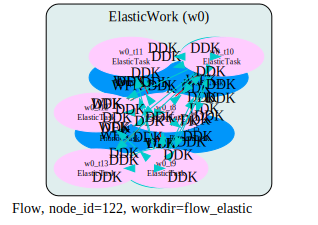

In [9]:
flow.get_graphviz()

In [10]:
# matplotlib version based on networkx
#flow.plot_networkx(with_edge_labels=True);

In a nutshell:

   * we compute the `WFK` file in the `ScfTask` (red circle)
   * the ground-state wavefunctions are used by the three `DdkTasks` to compute
     $\dfrac{\partial u}{\partial{\bf k}}$ for the three different directions.
   * The `ElasticTasks` needs the `WFK` file to compute the six strain perturbations
     (3 for uniaxial and 3 for shear strain) while the `DDK` files are required
     to compute the mixed 2nd-order derivatives with respect to strain and electric field
     needed for the piezoelectric tensor.

Note that, **contrarily to the approach used in the standard tutorial**, the AbiPy `Work` does not use datasets.
The perturbations of interest (strain, atomic-perturbation, ddk, electric field)
are obtained with different `Tasks` that can be executed in parallel.

To understand better this point, we can print a table with the most important Abinit variables defining
the DFPT calculation.
If the variable is not present in the input, the entry is set to `None`.

In [11]:
flow.get_vars_dataframe("qpt", "rfphon", "rfatpol", "rfdir", "rfelfd", "rfstrs", "kptopt")

qpt rfphon rfatpol      rfdir rfelfd rfstrs kptopt        class
w0_t0        None   None    None       None   None   None   None      ScfTask
w0_t1   (0, 0, 0)   None    None  (1, 0, 0)      2   None      2      DdkTask
w0_t2   (0, 0, 0)   None    None  (0, 1, 0)      2   None      2      DdkTask
w0_t3   (0, 0, 0)   None    None  (0, 0, 1)      2   None      2      DdkTask
w0_t4   (0, 0, 0)      1  [1, 1]  [1, 0, 0]   None   None      2   PhononTask
w0_t5   (0, 0, 0)      1  [1, 1]  [0, 0, 1]   None   None      2   PhononTask
w0_t6   (0, 0, 0)      1  [3, 3]  [1, 0, 0]   None   None      2   PhononTask
w0_t7   (0, 0, 0)      1  [3, 3]  [0, 0, 1]   None   None      2   PhononTask
w0_t8   (0, 0, 0)   None    None  [1, 0, 0]   None      1      2  ElasticTask
w0_t9   (0, 0, 0)   None    None  [0, 1, 0]   None      1      2  ElasticTask
w0_t10  (0, 0, 0)   None    None  [0, 0, 1]   None      1      2  ElasticTask
w0_t11  (0, 0, 0)   None    None  [1, 0, 0]   None      2      2  ElasticTask
w0_t12  (0, 0, 0)   None    None  [0, 1, 0]   None      2      2  ElasticTask
w0_t13  (0, 0, 0)   None    None  [0, 0, 1]   None      2      2  ElasticTask

If the meaning of these variables is not clear, you can consult the [Abinit documentation](https://docs.abinit.org)
or access the documentation directly from python with *e.g.*:

In [12]:
abilab.docvar("rfstrs")

rfstrs  <Response Function with respect to STRainS>

```{note}
For your convenience the links to the doc of the different variables are listed below:

- {{qpt}}
- {{rfphon}}
- {{rfatpol}}
- {{rfdir}}
- {{rfelfd}}
- {{rfstrs}}
- {{kptopt}}
```

Now we can generate the `flow_elastic` directory with the input files by executing the `lesson_elastic.py` script.
Then use the {{abirun}} script to launch the entire calculation with:

    abirun.py flow_elastic scheduler

You will see that all `PhononTasks` and `ElasticTasks` are executed in parallel on your machine
once the three `DdkTasks` are completed.

```{include} ../snippets/abicheck_warning.md
```

If you prefer to skip this part, you may want to jump to next section about the post-processing of the results.
Note that the output files are already available in the repository so it is also possible to try
the AbiPy post-processing tools without having to run the flow.

## Post-processing the results

Our flow is completed and we have the final DDB file
in the `outdata` directory of the `Work` (AbiPy has automatically merged all the partial DDB files
at the end of the calculation by invoking `anaddb` for you).
Let's open this DDB file with:

In [13]:
ddb = abilab.abiopen("flow_elastic/w0/outdata/out_DDB")
print(ddb)

================================= File Info =================================
Name: out_DDB
Directory: /home/runner/work/abipy_book/abipy_book/abipy_book/elastic/flow_elastic/w0/outdata
Size: 27.03 kB
Access Time: Sun Oct 27 17:42:03 2024
Modification Time: Sun Oct 27 17:38:46 2024
Change Time: Sun Oct 27 17:38:46 2024

================================= Structure =================================
Full Formula (Al2 As2)
Reduced Formula: AlAs
abc   :   3.989448   3.989448   6.497130
angles:  90.000000  90.000000 120.000000
pbc   :       True       True       True
Sites (4)
  #  SP           a         b         c  cartesian_forces
---  ----  --------  --------  --------  -------------------------------------------------
  0  Al    0.333333  0.666667  0         [-0.00000000e+00 -0.00000000e+00  4.06423231e-06]
  1  Al    0.666667  0.333333  0.5       [-0.00000000e+00 -0.00000000e+00  4.06423231e-06]
  2  As    0.333333  0.666667  0.376086  [-0.00000000e+00 -0.00000000e+00 -4.06423231e-06]


The `DdbFile` object provides an easy-to-use interface that invokes `anaddb` to post-process
the data stored in the DDB file.
All the methods that invoke `anaddb` use the `ana` prefix so it is not strange to
see that we can obtain the elastic and piezoelectric tensors by just calling:

In [14]:
edata = ddb.anaget_elastic(verbose=1)

ANADDB INPUT:
  outdata_prefix "outdata/out"
 asr 2
 chneut 1
 dieflag 0
 elaflag 3
 piezoflag 3
 instrflag 1
workdir: /tmp/tmpsuvqtekr


Note that we are calling the method without arguments. This means that AbiPy will try to detect
**automatically** how to set the anaddb input variables.
The docstring of the method explains the logic used to set the variables.

In [15]:
abilab.print_doc(ddb.anaget_elastic)

Let's print the object to get a summary of the most important results:

In [16]:
print(edata)

================================= Structure =================================
Full Formula (Al2 As2)
Reduced Formula: AlAs
abc   :   3.989448   3.989448   6.497130
angles:  90.000000  90.000000 120.000000
pbc   :       True       True       True
Sites (4)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  Al    0.333333  0.666667  0
  1  Al    0.666667  0.333333  0.5
  2  As    0.333333  0.666667  0.376086
  3  As    0.666667  0.333333  0.876086

============================== Anaddb Variables ==============================
{
  "asr": 2,
  "chneut": 1,
  "dieflag": 0,
  "elaflag": 3,
  "instrflag": 1,
  "piezoflag": 3
}

========================= elastic tensors available =========================
[ELASTIC_RELAXED]
relaxed-ion elastic tensor in Voigt notation (shape: (6, 6))
Units: GPa, set to zero below: 0.001, fit_to_structure: True

            xx          yy          zz        yz         xz         xy
xx  135.262182   54.450376   38.052927   0.0000

Since the DDB file contains `internal strain terms` and piezoelectric terms,
AbiPy set `elaflag` to 3, `instrflag` to 1 and `piezoflag` to 3 so that anaddb
will compute both `relaxed` and `clamped-ion` tensors.

In [17]:
abilab.docvar("elaflag", executable="anaddb")

elaflag@anaddb  <ELAstic tensor FLAG>

The tensors are available as attributes of the `edata` object:

In [18]:
edata.elastic_relaxed

MyElasticTensor([[[[ 1.35262182e+02  3.86872778e-07  7.68078576e-08]
   [ 3.86872778e-07  5.44503761e+01 -2.34729999e-09]
   [ 7.68078576e-08 -2.34729999e-09  3.80529272e+01]]

  [[ 2.23597953e-07  4.04059029e+01 -1.04441413e-09]
   [ 4.04059029e+01 -5.56918764e-07  4.85287557e-09]
   [-1.04441413e-09  4.85287557e-09 -5.11644117e-08]]

  [[ 8.37849888e-08 -1.04444344e-09  3.05507088e+01]
   [-1.04444344e-09 -3.34035225e-08 -7.82061279e-09]
   [ 3.05507088e+01 -7.82061279e-09 -2.55296131e-08]]]


 [[[ 2.23597953e-07  4.04059029e+01 -1.04441413e-09]
   [ 4.04059029e+01 -5.56918764e-07  4.85287557e-09]
   [-1.04441413e-09  4.85287557e-09 -5.11644117e-08]]

  [[ 5.44503755e+01 -6.93954124e-07 -2.49674821e-08]
   [-6.93954124e-07  1.35262181e+02  3.75489657e-09]
   [-2.49674821e-08  3.75489657e-09  3.80529266e+01]]

  [[ 3.87661429e-09  4.99024214e-09 -7.82059494e-09]
   [ 4.99024214e-09  6.92339892e-09  3.05507104e+01]
   [-7.82059494e-09  3.05507104e+01  4.33875176e-09]]]


 [[[ 8.37849888e-08 -1.04444344e-09  3.05507088e+01]
   [-1.04444344e-09 -3.34035225e-08 -7.82061279e-09]
   [ 3.05507088e+01 -7.82061279e-09 -2.55296131e-08]]

  [[ 3.87661429e-09  4.99024214e-09 -7.82059494e-09]
   [ 4.99024214e-09  6.92339892e-09  3.05507104e+01]
   [-7.82059494e-09  3.05507104e+01  4.33875176e-09]]

  [[ 3.80529269e+01  2.82167427e-07 -3.01436764e-08]
   [ 2.82167427e-07  3.80529257e+01 -1.28501813e-09]
   [-3.01436764e-08 -1.28501813e-09  1.48211029e+02]]]])

These are pymatgen tensors,
more specifically [ElasticTensor objects](https://github.com/materialsproject/pymatgen/blob/master/src/pymatgen/analysis/elasticity/elastic.py)
so we have access to several useful methods.
To get the Voigt bulk modulus, use:

In [19]:
edata.elastic_relaxed.k_voigt

75.5386499927217

while the compliance tensor is easily obtained with:

In [20]:
edata.elastic_relaxed.compliance_tensor

ComplianceTensor([[[[ 9.12540966e-03 -6.63185579e-11 -1.35430962e-11]
   [-6.63185579e-11 -3.24901993e-03  5.18499125e-13]
   [-1.35430962e-11  5.18499125e-13 -1.50875299e-03]]

  [[-4.85950967e-11  6.18721480e-03  2.11517754e-13]
   [ 6.18721480e-03  7.09227024e-11 -9.82817856e-13]
   [ 2.11517754e-13 -9.82817856e-13 -1.46075699e-12]]

  [[-1.49197674e-11  2.11523732e-13  8.18311620e-03]
   [ 2.11523732e-13  8.81357700e-12  2.09477889e-12]
   [ 8.18311620e-03  2.09477889e-12  4.38686654e-12]]]


 [[[-4.85950967e-11  6.18721480e-03  2.11517754e-13]
   [ 6.18721480e-03  7.09227024e-11 -9.82817856e-13]
   [ 2.11517754e-13 -9.82817856e-13 -1.46075699e-12]]

  [[-3.24901988e-03  9.91846910e-11  7.06872960e-12]
   [ 9.91846910e-11  9.12540970e-03 -7.17334705e-13]
   [ 7.06872960e-12 -7.17334705e-13 -1.50875296e-03]]

  [[-1.03685440e-13 -1.01063771e-12  2.09477411e-12]
   [-1.01063771e-12 -7.20728753e-13  8.18311576e-03]
   [ 2.09477411e-12  8.18311576e-03 -2.67440577e-13]]]


 [[[-1.491976

One can also use the [elate](http://progs.coudert.name/elate) online tool to analyse the elastic tensor.

To build a pandas DataFrame with properties derived from the elastic tensor
and the associated structure, use:

In [21]:
edata.get_elastic_properties_dataframe(properties_as_index=True)

property             0             1
0                trans_v  3.194459e+03  3.838052e+03
1                 long_v  5.796035e+03  6.295200e+03
2              snyder_ac  5.767044e+01  8.693459e+01
3             snyder_opt  3.158141e-01  3.621134e-01
4           snyder_total  5.798626e+01  8.729670e+01
5     clarke_thermalcond  7.734051e-01  9.006348e-01
6     cahill_thermalcond  8.539415e-01  9.791319e-01
7      debye_temperature  3.760623e+02  4.477874e+02
8                k_voigt  7.553865e+01  7.553930e+01
9                k_reuss  7.553074e+01  7.553579e+01
10                 k_vrh  7.553469e+01  7.553754e+01
11               g_voigt  3.951341e+01  5.767416e+01
12               g_reuss  3.761300e+01  5.366047e+01
13                 g_vrh  3.856321e+01  5.566731e+01
14  universal_anisotropy  2.527308e-01  3.740360e-01
15   homogeneous_poisson  2.818554e-01  2.041909e-01
16                 y_mod  9.886491e+10  1.340681e+11

For the meaning of the different quantities please consult the
[pymatgen module](https://github.com/materialsproject/pymatgen/blob/master/src/pymatgen/analysis/elasticity/elastic.py).

To construct a dataframe with the Voigt indices and the tensor elements use:

In [22]:
edata.get_elastic_voigt_dataframe(tol=1e-5)

voigt_cinds  elastic_relaxed  elastic_clamped
0       (0, 0)       135.262182       165.988592
1       (0, 1)        54.450376        40.464803
2       (0, 2)        38.052927        21.090298
3       (0, 3)         0.000000         0.000000
4       (0, 4)         0.000000         0.000000
5       (0, 5)         0.000000         0.000000
6       (1, 0)        54.450376        40.464802
7       (1, 1)       135.262181       165.988592
8       (1, 2)        38.052927        21.090299
9       (1, 3)         0.000000         0.000000
10      (1, 4)         0.000000         0.000000
11      (1, 5)         0.000000         0.000000
12      (2, 0)        38.052927        21.090298
13      (2, 1)        38.052926        21.090298
14      (2, 2)       148.211029       182.585743
15      (2, 3)         0.000000         0.000000
16      (2, 4)         0.000000         0.000000
17      (2, 5)         0.000000         0.000000
18      (3, 0)         0.000000         0.000000
19      (3, 1)         0.000000         0.000000
20      (3, 2)         0.000000         0.000000
21      (3, 3)        30.550710        40.818194
22      (3, 4)         0.000000         0.000000
23      (3, 5)         0.000000         0.000000
24      (4, 0)         0.000000         0.000000
25      (4, 1)         0.000000         0.000000
26      (4, 2)         0.000000         0.000000
27      (4, 3)         0.000000         0.000000
28      (4, 4)        30.550709        40.818195
29      (4, 5)         0.000000         0.000000
30      (5, 0)         0.000000         0.000000
31      (5, 1)         0.000000         0.000000
32      (5, 2)         0.000000         0.000000
33      (5, 3)         0.000000         0.000000
34      (5, 4)         0.000000         0.000000
35      (5, 5)        40.405903        62.761895

Note that the Voigt indices are given following the Python (C) notation
in which we start to count from zero.

This might be a bit confusing, especially when comparing with results reported in the literature.
The reason why we opted with the 0-based notation is that it facilitates the integration between
the DataFrame and other python methods.
A similar approach is used in AbiPy when e.g. one has to specify the band or the phonon mode index.

At this point, it should be clear how to analyze the *relaxed-ion* piezoelectric tensor:

In [23]:
edata.piezo_relaxed

MyPiezoTensor([[[ 1.75409585e-09  3.86140603e-11 -4.82884490e-02]
  [ 3.86140603e-11 -1.29936258e-09 -8.89549419e-13]
  [-4.82884490e-02 -8.89549419e-13 -1.18917273e-11]]

 [[ 5.01757913e-12  2.85370175e-11 -8.00602698e-13]
  [ 2.85370175e-11  1.03270778e-10 -4.82883778e-02]
  [-8.00602698e-13 -4.82883778e-02  1.04468440e-11]]

 [[-1.18716022e-02 -8.38243007e-09  1.10922123e-09]
  [-8.38243007e-09 -1.18715660e-02  4.49488923e-11]
  [ 1.10922123e-09  4.49488923e-11  6.46276918e-02]]])

In [24]:
edata.get_piezo_voigt_dataframe(tol=1e-6)

voigt_cinds  piezo_relaxed  piezo_clamped
0       (0, 0)       0.000000       0.000000
1       (0, 1)       0.000000       0.000000
2       (0, 2)       0.000000       0.000000
3       (0, 3)       0.000000       0.000000
4       (0, 4)      -0.048288       0.435488
5       (0, 5)       0.000000       0.000000
6       (1, 0)       0.000000       0.000000
7       (1, 1)       0.000000       0.000000
8       (1, 2)       0.000000       0.000000
9       (1, 3)      -0.048288       0.435488
10      (1, 4)       0.000000       0.000000
11      (1, 5)       0.000000       0.000000
12      (2, 0)      -0.011872       0.384901
13      (2, 1)      -0.011872       0.384901
14      (2, 2)       0.064628      -0.739430
15      (2, 3)       0.000000       0.000000
16      (2, 4)       0.000000       0.000000
17      (2, 5)       0.000000       0.000000

## Convergence study wrt the number of k-points

In this part of the tutorial, we discuss how to compute elastic and piezoelectric
tensors with different k-point meshes and how to use the `DdbRobot` to analyze the results.

In principle, one should relax the structure with different k-point samplings and then
use the relaxed structure to compute elastic and piezoelectric properties.
This is easy with AbiPy but, for the time being, we ignore this point and use
the same structure so that we can learn how to use Python to analyze multiple calculations.
At the end of this tutorial you will find an example of flow in which the structural relaxation
is performed with different k-meshes.

Since we do not have to change the structure, performing a convergence study with respect to k-points
is just a matter of creating multiple `Works` inside a loop over k-meshes (our `make_scf_input`
is already accepting `ngkpt` in input):

In [25]:
from lesson_elastic import build_ngkpt_convflow
abilab.print_source(build_ngkpt_convflow)

In [26]:
ngkpt_flow = build_ngkpt_convflow(options=None, ngkpt_list=([2, 2, 2], [4, 4, 4], [8, 8, 8]))

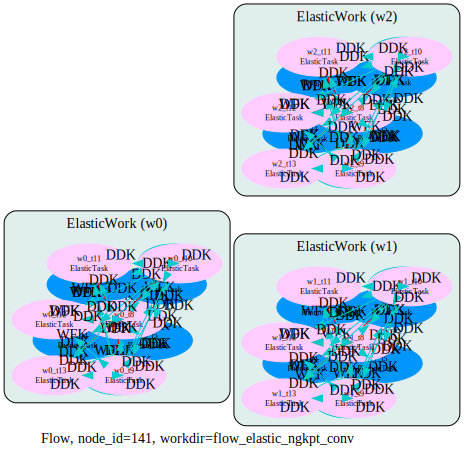

In [27]:
ngkpt_flow.get_graphviz()

In [28]:
#ngkpt_flow.get_vars_dataframe("ngkpt")

To generate the flow with the `lesson_elastic.py` script, open the file,
comment the call to `build_flow` and uncomment `build_ngkpt_convflow`.
Then run the script and launch the calculation with:

    abirun.py flow_elastic_ngkpt_conv scheduler

as usual.

There are several output files located inside the `outdata` directories:

In [29]:
!find flow_elastic_ngkpt_conv/ -name "*_DDB"

flow_elastic_ngkpt_conv/w2/outdata/out_DDB
flow_elastic_ngkpt_conv/w1/outdata/out_DDB
flow_elastic_ngkpt_conv/w0/outdata/out_DDB


Remember that our goal is to analyze the convergence of the elastic and piezoelectric properties
as function of `nkpt`.
So we are mainly interested in the final DDB files located in the `outdata` directories
of the works (`w0/outdata`, `w1/outdata`, `w2/outdata`).
These are indeed the DDB files with all the information needed in anaddb to compute the tensors.

The code below tells our robot that we would like to analyze all the DDB files
located in the output directories of the works:

In [30]:
robot = abilab.DdbRobot.from_dir_glob("./flow_elastic_ngkpt_conv/w*/outdata/")
robot

Label                                       Relpath
------------------------------------------  ------------------------------------------
flow_elastic_ngkpt_conv/w2/outdata/out_DDB  flow_elastic_ngkpt_conv/w2/outdata/out_DDB
flow_elastic_ngkpt_conv/w1/outdata/out_DDB  flow_elastic_ngkpt_conv/w1/outdata/out_DDB
flow_elastic_ngkpt_conv/w0/outdata/out_DDB  flow_elastic_ngkpt_conv/w0/outdata/out_DDB

The DDB file are available in `robot.abifile`.
Each `DdbFile` object has a header (dictionary) containing metadata extracted from the DDB file.
To get the keywords in the header, use:

In [31]:
robot.abifiles[0].header.keys()

dict_keys(['version', 'lines', 'usepaw', 'natom', 'nkpt', 'nsppol', 'nsym', 'ntypat', 'occopt', 'nband', 'acell', 'amu', 'dilatmx', 'ecut', 'ecutsm', 'intxc', 'iscf', 'ixc', 'kpt', 'kptnrm', 'ngfft', 'nspden', 'nspinor', 'occ', 'rprim', 'dfpt_sciss', 'spinat', 'symafm', 'symrel', 'tnons', 'tolwfr', 'tphysel', 'tsmear', 'typat', 'wtk', 'xred', 'znucl', 'zion'])

We will be using these meta variables to construct our pandas Dataframe so that we can analyze
the convergence of our physical quantities with e.g. `nkpt`.

Let's call `anacompare_elastic` to construct a DataFrame (`data`) with the elastic properties obtained
with the three DDB files and add the value of `ddb.header["nkpt"]`.
`elastdata_list` is a list of `ElastData` object we can use afterwards to access the individual tensors:

In [32]:
data, elastdata_list = robot.anacompare_elastic(ddb_header_keys="nkpt")

In [33]:
data.keys()

Index(['trans_v', 'long_v', 'snyder_ac', 'snyder_opt', 'snyder_total',
       'clarke_thermalcond', 'cahill_thermalcond', 'debye_temperature',
       'k_voigt', 'k_reuss', 'k_vrh', 'g_voigt', 'g_reuss', 'g_vrh',
       'universal_anisotropy', 'homogeneous_poisson', 'y_mod', 'tensor_name',
       'formula', 'nkpt', 'natom', 'alpha', 'beta', 'gamma', 'a', 'b', 'c',
       'volume', 'abispg_num', 'spglib_symb', 'spglib_num',
       'spglib_lattice_type'],
      dtype='object')

In [34]:
data

trans_v       long_v  snyder_ac  snyder_opt  snyder_total  \
0  3187.357490  5761.696015  56.983956    0.314556     57.298512   
1  3849.753468  6277.945639  87.049415    0.362273     87.411688   
2  3194.458696  5796.034979  57.670442    0.315814     57.986256   
3  3838.051896  6295.200076  86.934586    0.362113     87.296699   
4  3151.515933  5705.015874  55.194905    0.311229     55.506134   
5  3753.376690  6179.896893  81.728454    0.354736     82.083190   

   clarke_thermalcond  cahill_thermalcond  debye_temperature    k_voigt  \
0            0.770980            0.850540         375.118016  74.267964   
1            0.901308            0.979563         448.886026  74.268035   
2            0.773405            0.853941         376.062257  75.538650   
3            0.900635            0.979132         447.787424  75.539303   
4            0.762578            0.841544         370.940943  73.572019   
5            0.882070            0.959183         438.077881  73.667176   

     k_reuss  ...  beta  gamma         a         b        c     volume  \
0  74.258479  ...  90.0  120.0  3.989448  3.989448  6.49713  89.552529   
1  74.260840  ...  90.0  120.0  3.989448  3.989448  6.49713  89.552529   
2  75.530735  ...  90.0  120.0  3.989448  3.989448  6.49713  89.552529   
3  75.535785  ...  90.0  120.0  3.989448  3.989448  6.49713  89.552529   
4  72.331727  ...  90.0  120.0  3.989448  3.989448  6.49713  89.552529   
5  73.014097  ...  90.0  120.0  3.989448  3.989448  6.49713  89.552529   

   abispg_num spglib_symb spglib_num  spglib_lattice_type  
0           0      P6_3mc        186            hexagonal  
1           0      P6_3mc        186            hexagonal  
2           0      P6_3mc        186            hexagonal  
3           0      P6_3mc        186            hexagonal  
4           0      P6_3mc        186            hexagonal  
5           0      P6_3mc        186            hexagonal  

[6 rows x 32 columns]

In [35]:
data[["k_voigt", "nkpt", "tensor_name"]]

k_voigt  nkpt      tensor_name
0  74.267964    40  elastic_relaxed
1  74.268035    40  elastic_clamped
2  75.538650     8  elastic_relaxed
3  75.539303     8  elastic_clamped
4  73.572019     2  elastic_relaxed
5  73.667176     2  elastic_clamped

To plot the convergence of selected properties versus the number of k-points, use:

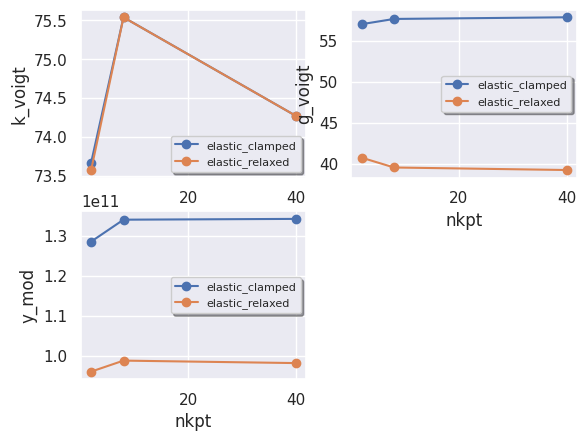

In [36]:
robot.plot_xy_with_hue(data, x="nkpt", y=["k_voigt", "g_voigt", "y_mod"], hue="tensor_name");

For more examples on the use of DDB and robots, see the
[DDB notebook](https://nbviewer.jupyter.org/github/abinit/abitutorials/blob/master/abitutorials/ddb.ipynb)

Now let's try something a bit more complicated.
Assume we want to plot the convergence of the individual elements of the tensor as as function of `nkpt`.
In this case, we have to work a bit more to create a Dataframe with the elements in Voigt notation,
add the value of `nkpt` associated to this tensor and finally concatenate the results in a single DataFrame:

In [37]:
df_list = []
for edata, ddb in zip(elastdata_list, robot.abifiles):

    # Get dataframe with tensor elements in Voigt notation
    df = edata.get_elastic_voigt_dataframe()

    # Add metadata and store dataframe in df_list
    df["nkpt"] = ddb.header["nkpt"]
    df_list.append(df)

# Concatenate dataframes
import pandas as pd
data = pd.concat(df_list)
data.head()

voigt_cinds  elastic_relaxed  elastic_clamped  nkpt
0      (0, 0)     1.309889e+02     1.628166e+02    40
1      (0, 1)     5.249070e+01     3.820562e+01    40
2      (0, 2)     3.807428e+01     2.045653e+01    40
3      (0, 3)     4.710262e-09     4.611456e-09    40
4      (0, 4)     7.390751e-08    -5.268783e-09    40

To select only the (0, 0) elements, use the syntax:

In [38]:
c00 = data[data["voigt_cinds"] == (0, 0)]
c00

voigt_cinds  elastic_relaxed  elastic_clamped  nkpt
0      (0, 0)       130.988919       162.816606    40
0      (0, 0)       135.262182       165.988592     8
0      (0, 0)       152.688699       177.895515     2

Now we can finally plot the (0, 0) tensor elements as function of `nkpt` with:

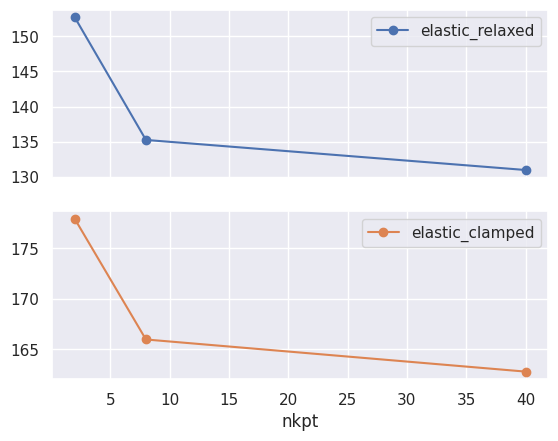

In [39]:
c00.plot(x="nkpt", y=[k for k in c00 if k.startswith("elastic_")], subplots=True, style="-o");